In [1]:
!pip install rasterio
!pip install shapely
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
image_path = '../temp/sentinel2_visual_20220604.tif'
model_path = '../models/2025-03-31_15-44-14.keras'

In [3]:
from tensorflow.keras.models import load_model

# Load the Keras model (ensure you have TensorFlow installed)
model = load_model(model_path)

2025-04-29 14:20:06.417617: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 14:20:06.711707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745961606.822843    3874 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745961606.852512    3874 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 14:20:07.117981: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
import rasterio

# Open the GeoTIFF file
with rasterio.open(image_path) as src:
    # Read all bands (or select bands as needed)
    image = src.read()  # shape: (channels, height, width)
    transform = src.transform  # Affine transformation matrix
    crs = src.crs  # Coordinate Reference System

# Extract pixel resolution from the transform:
pixel_width = transform.a        # pixel size in x direction
pixel_height = -transform.e      # pixel size in y (use absolute value)

print(pixel_width, pixel_height)

10.0 10.0


In [5]:
import numpy as np
from tensorflow.keras.models import load_model
import rasterio
import matplotlib.pyplot as plt

# Parameters
patch_size = 128
threshold = 0.5  # adjust based on your model's calibration

# 1. Load the GeoTIFF
with rasterio.open(image_path) as src:
    # Read all bands; shape: (channels, height, width)
    image = src.read()
    transform = src.transform

# 2. Preprocess the Image
# Remove the batch dimension (if any) and adjust channels.
# Assuming your model was trained on the first 3 channels, drop the 4th channel.
# image currently has shape (4, H, W); we convert to (H, W, 3)
image = image[0:3, :, :]             # shape now (3, H, W)
image = np.transpose(image, (1, 2, 0)) # now shape: (H, W, 3)
H, W, _ = image.shape

# (Optional) Normalize the image if required by your model
# For example, if pixel values are in [0, 255]:
image = image / 255.0

# 4. Patchify the Image and Run Inference
# We'll process the image in non-overlapping patches of size 128x128
n_h = H // patch_size  # number of patches along height
n_w = W // patch_size  # number of patches along width

# Pre-allocate an empty full-size mask
full_mask = np.zeros((H, W), dtype=np.uint8)

# Loop over patches, predict, and assemble the mask
for i in range(n_h):
    for j in range(n_w):
        # Extract patch
        patch = image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]

        # Expand dimensions to create a batch of one image
        patch_input = np.expand_dims(patch, axis=0)  # shape: (1, 128, 128, 3)

        # Run inference on the patch
        patch_pred = model.predict(patch_input)
        patch_pred = np.squeeze(patch_pred)  # shape: (128, 128)

        # Convert prediction to binary mask using thresholding
        binary_patch = (patch_pred > threshold).astype(np.uint8)

        # Place the binary patch into the corresponding location in the full mask
        full_mask[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = binary_patch


/home/yifan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
I0000 00:00:1745961633.940964    6807 service.cc:148] XLA service 0x7f207000d1d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745961633.941135    6807 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-04-29 14:20:33.962168: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745961634.033076    6807 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-29 14:20:34.374670: I external/local_xla/xla/ser

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


I0000 00:00:1745961635.078102    6807 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

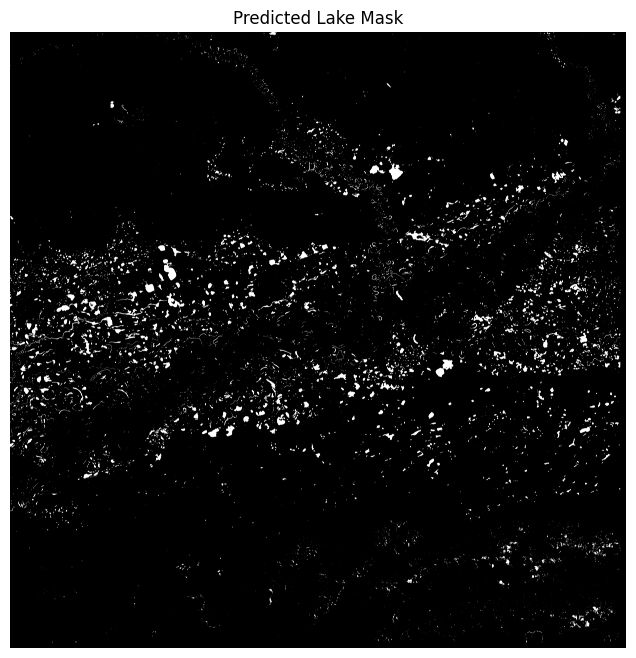

In [6]:
# 5. (Optional) Visualize a Portion of the Prediction
plt.figure(figsize=(8, 8))
plt.imshow(full_mask, cmap='gray')
plt.title("Predicted Lake Mask")
plt.axis('off')
plt.show()

In [7]:
binary_mask = full_mask

print("Pixel width:", pixel_width)
print("Pixel height:", pixel_height)

pixel_area = pixel_width * pixel_height
print("Pixel area:", pixel_area)

total_pixels = binary_mask.size
print("Total number of pixels:", total_pixels)

lake_pixel_count = np.sum(binary_mask)
print("Number of lake pixels:", lake_pixel_count)

total_area = total_pixels * pixel_area
print("Total area:", total_area)

total_lake_area = lake_pixel_count * pixel_area
print("Total lake area:", total_lake_area)

non_lake_area= total_area - total_lake_area
print("Total non lake area:", non_lake_area, "square meters")

non_lake_pixel_count = total_pixels - lake_pixel_count
fraction_non_lake = non_lake_pixel_count / total_pixels
print("Fraction of area that is not lake:", fraction_non_lake)

Pixel width: 10.0
Pixel height: 10.0
Pixel area: 100.0
Total number of pixels: 120560400
Number of lake pixels: 3508523
Total area: 12056040000.0
Total lake area: 350852300.0
Total non lake area: 11705187700.0 square meters
Fraction of area that is not lake: 0.9708982136754689


In [8]:
from skimage.measure import label, regionprops
binary_mask = full_mask
# Label connected regions in the binary mask (each region represents a separate lake)
labeled_mask = label(binary_mask)

# Get region properties for each lake
regions = regionprops(labeled_mask)

# Calculate and print area for each lake
for region in regions:
    lake_area = region.area * pixel_area
    print(f"Lake ID: {region.label}, Area: {lake_area:.2f} square meters")

Lake ID: 1, Area: 475300.00 square meters
Lake ID: 2, Area: 100.00 square meters
Lake ID: 3, Area: 100.00 square meters
Lake ID: 4, Area: 700.00 square meters
Lake ID: 5, Area: 8600.00 square meters
Lake ID: 6, Area: 2600.00 square meters
Lake ID: 7, Area: 77700.00 square meters
Lake ID: 8, Area: 500.00 square meters
Lake ID: 9, Area: 3100.00 square meters
Lake ID: 10, Area: 4600.00 square meters
Lake ID: 11, Area: 7900.00 square meters
Lake ID: 12, Area: 100.00 square meters
Lake ID: 13, Area: 1000.00 square meters
Lake ID: 14, Area: 20200.00 square meters
Lake ID: 15, Area: 100.00 square meters
Lake ID: 16, Area: 1300.00 square meters
Lake ID: 17, Area: 300.00 square meters
Lake ID: 18, Area: 400.00 square meters
Lake ID: 19, Area: 16600.00 square meters
Lake ID: 20, Area: 100.00 square meters
Lake ID: 21, Area: 800.00 square meters
Lake ID: 22, Area: 6600.00 square meters
Lake ID: 23, Area: 900.00 square meters
Lake ID: 24, Area: 300.00 square meters
Lake ID: 25, Area: 12900.00 squa

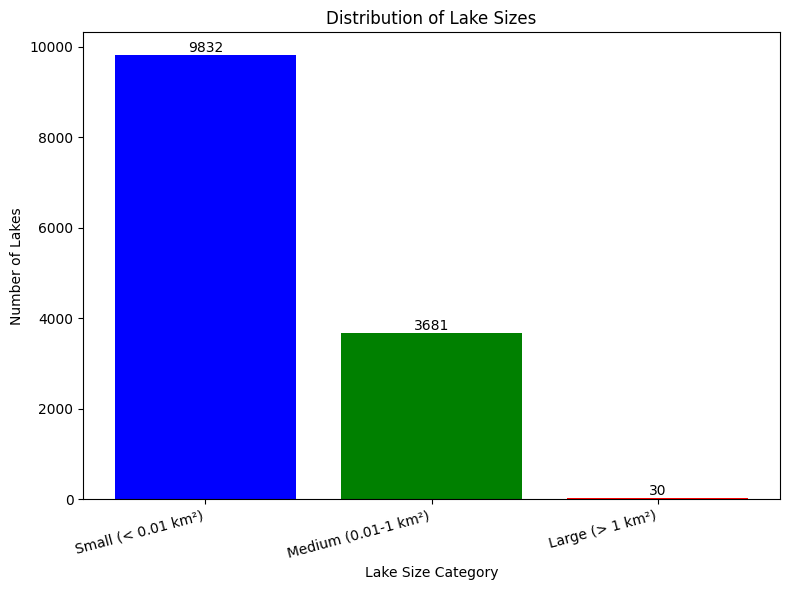

In [16]:
import numpy as np
import matplotlib.pyplot as plt

lake_categories = [
    {"name": "Small (< 0.01 km²)", "min_area": 0, "max_area": 10000, "color": "blue"},
    {"name": "Medium (0.01-1 km²)", "min_area": 10000, "max_area": 1000000, "color": "green"},
    {"name": "Large (> 1 km²)", "min_area": 1000000, "max_area": float('inf'), "color": "red"}
]

lake_counts = {category["name"]: 0 for category in lake_categories}

for region in regions:
    lake_area_m2 = region.area * pixel_area
    for category in lake_categories:
        if category["min_area"] <= lake_area_m2 < category["max_area"]:
            lake_counts[category["name"]] += 1
            break

categories = [category["name"] for category in lake_categories]
counts = [lake_counts[category] for category in categories]
colors = [category["color"] for category in lake_categories]

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, counts, color=colors)
plt.xlabel("Lake Size Category")
plt.ylabel("Number of Lakes")
plt.title("Distribution of Lake Sizes")
plt.xticks(rotation=15, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [12]:
import rasterio
import os

# Assuming you already have:
# - full_mask: a numpy array with shape (H, W)
# - transform: the affine transform extracted from your original GeoTIFF
# - crs: the coordinate reference system from your original GeoTIFF

# create /temp/output folder if it doesn't exist
os.makedirs('../temp/output', exist_ok=True)

output_filename = '../temp/output/predicted_lake_mask-20220604.tif'

with rasterio.open(
    output_filename,
    'w',
    driver='GTiff',
    height=full_mask.shape[0],
    width=full_mask.shape[1],
    count=1,  # one band for the binary mask
    dtype=full_mask.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(full_mask, 1)  # Write the mask to band 1

print("GeoTIFF saved as:", output_filename)

GeoTIFF saved as: ../temp/output/predicted_lake_mask-20220604.tif


In [11]:
import rasterio.features
from shapely.geometry import shape
import geopandas as gpd

# 'full_mask' is your binary mask (numpy array, shape: (H, W))
# 'transform' and 'crs' were obtained from reading your original GeoTIFF

# Extract polygons from the binary mask
# This will return all shapes (both 0 and 1 values), so we filter for lakes (value==1)
results = list(rasterio.features.shapes(full_mask, transform=transform))
lake_polygons = [shape(geom) for geom, value in results if value == 1]

# Optionally, you can filter out very small polygons here if needed
# lake_polygons = [poly for poly in lake_polygons if poly.area > some_threshold]

# Create a GeoDataFrame with the same CRS as your original GeoTIFF
gdf = gpd.GeoDataFrame({'lake_id': range(1, len(lake_polygons) + 1),
                        'geometry': lake_polygons},
                       crs=crs)

# Save the GeoDataFrame to a GeoJSON file
output_geojson = "../temp/output/predicted_lake_mask-20220604-lakes.geojson"
gdf.to_file(output_geojson, driver="GeoJSON")
print("GeoJSON saved as:", output_geojson)

GeoJSON saved as: ../temp/output/predicted_lake_mask-20220604-lakes.geojson


In [ ]:
# Testing it on Planet

In [31]:
import rasterio

# Open the GeoTIFF file
with rasterio.open('20240721_222423_48_24f3_3B_Visual_clip_file_format.tif') as src:
    # Read all bands (or select bands as needed)
    image = src.read()  # shape: (channels, height, width)
    transform = src.transform  # Affine transformation matrix
    crs = src.crs  # Coordinate Reference System

# Extract pixel resolution from the transform:
pixel_width = transform.a        # pixel size in x direction
pixel_height = -transform.e      # pixel size in y (use absolute value)

print(pixel_width, pixel_height)

RasterioIOError: 20240721_222423_48_24f3_3B_Visual_clip_file_format.tif: No such file or directory

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━

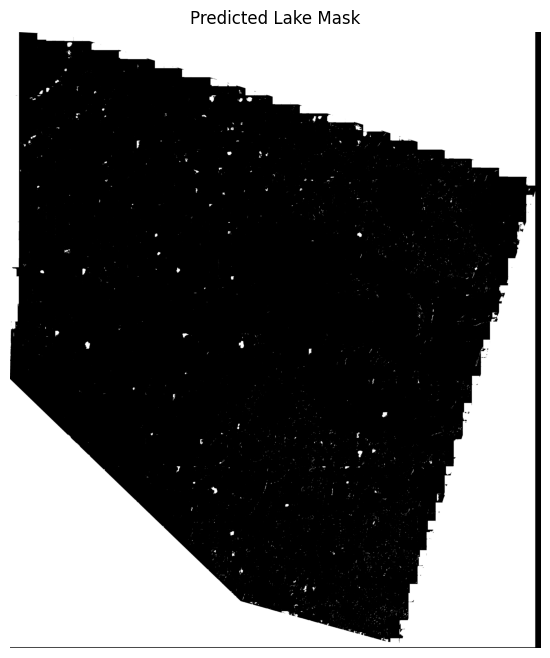

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
import rasterio
import matplotlib.pyplot as plt

# Parameters
patch_size = 128
threshold = 0.5  # adjust based on your model's calibration

# 1. Load the GeoTIFF
with rasterio.open('20240721_222423_48_24f3_3B_Visual_clip_file_format.tif') as src:
    # Read all bands; shape: (channels, height, width)
    image = src.read()
    transform = src.transform

# 2. Preprocess the Image
# Remove the batch dimension (if any) and adjust channels.
# Assuming your model was trained on the first 3 channels, drop the 4th channel.
# image currently has shape (4, H, W); we convert to (H, W, 3)
image = image[0:3, :, :]             # shape now (3, H, W)
image = np.transpose(image, (1, 2, 0)) # now shape: (H, W, 3)
H, W, _ = image.shape

# (Optional) Normalize the image if required by your model
# For example, if pixel values are in [0, 255]:
image = image / 255.0

# 3. Load the Pre-trained Keras Model
model = load_model('2025-03-06_00-12-23.keras')

# 4. Patchify the Image and Run Inference
# We'll process the image in non-overlapping patches of size 128x128
n_h = H // patch_size  # number of patches along height
n_w = W // patch_size  # number of patches along width

# Pre-allocate an empty full-size mask
full_mask = np.zeros((H, W), dtype=np.uint8)

# Loop over patches, predict, and assemble the mask
for i in range(n_h):
    for j in range(n_w):
        # Extract patch
        patch = image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]

        # Expand dimensions to create a batch of one image
        patch_input = np.expand_dims(patch, axis=0)  # shape: (1, 128, 128, 3)

        # Run inference on the patch
        patch_pred = model.predict(patch_input)
        patch_pred = np.squeeze(patch_pred)  # shape: (128, 128)

        # Convert prediction to binary mask using thresholding
        binary_patch = (patch_pred > threshold).astype(np.uint8)

        # Place the binary patch into the corresponding location in the full mask
        full_mask[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = binary_patch

# 5. (Optional) Visualize a Portion of the Prediction
plt.figure(figsize=(8, 8))
plt.imshow(full_mask, cmap='gray')
plt.title("Predicted Lake Mask")
plt.axis('off')
plt.show()

In [ ]:
full_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

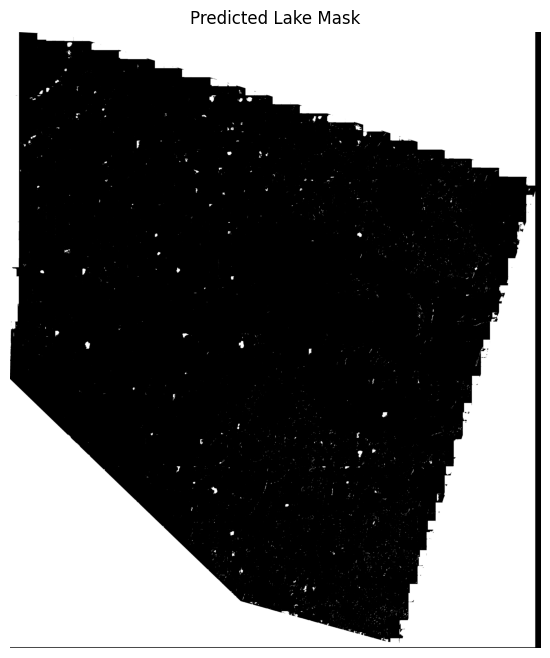

In [ ]:
# 5. (Optional) Visualize a Portion of the Prediction
plt.figure(figsize=(8, 8))
plt.imshow(full_mask, cmap='gray')
plt.title("Predicted Lake Mask")
plt.axis('off')
plt.show()

In [ ]:
binary_mask = full_mask
# Compute area per pixel (in square meters, if dimensions are in meters)
pixel_area = pixel_width * pixel_height

# Count the lake pixels
lake_pixel_count = np.sum(binary_mask)

# Compute the total lake area
total_lake_area = lake_pixel_count * pixel_area
print("Total lake area:", total_lake_area, "square meters")

Total lake area: 203844951.0 square meters


In [ ]:

from skimage.measure import label, regionprops

# Label connected regions in the binary mask (each region represents a separate lake)
labeled_mask = label(binary_mask)

# Get region properties for each lake
regions = regionprops(labeled_mask)

# Calculate and print area for each lake
for region in regions:
    lake_area = region.area * pixel_area
    print(f"Lake ID: {region.label}, Area: {lake_area:.2f} square meters")

Streaming output truncated to the last 5000 lines.
Lake ID: 1953, Area: 9.00 square meters
Lake ID: 1954, Area: 279.00 square meters
Lake ID: 1955, Area: 9.00 square meters
Lake ID: 1956, Area: 9.00 square meters
Lake ID: 1957, Area: 9.00 square meters
Lake ID: 1958, Area: 18.00 square meters
Lake ID: 1959, Area: 9.00 square meters
Lake ID: 1960, Area: 45.00 square meters
Lake ID: 1961, Area: 27.00 square meters
Lake ID: 1962, Area: 9.00 square meters
Lake ID: 1963, Area: 54.00 square meters
Lake ID: 1964, Area: 18.00 square meters
Lake ID: 1965, Area: 9.00 square meters
Lake ID: 1966, Area: 9.00 square meters
Lake ID: 1967, Area: 54.00 square meters
Lake ID: 1968, Area: 9.00 square meters
Lake ID: 1969, Area: 54.00 square meters
Lake ID: 1970, Area: 27.00 square meters
Lake ID: 1971, Area: 18.00 square meters
Lake ID: 1972, Area: 9.00 square meters
Lake ID: 1973, Area: 2151.00 square meters
Lake ID: 1974, Area: 18.00 square meters
Lake ID: 1975, Area: 63.00 square meters
Lake ID: 1976

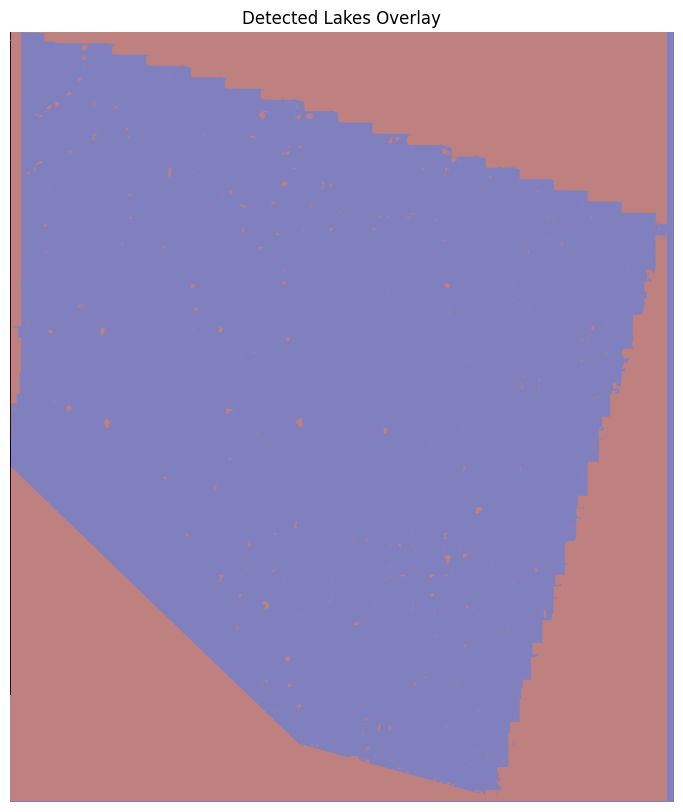

In [ ]:
import matplotlib.pyplot as plt

# Display the first band of the original image with the detected lake mask overlaid
plt.figure(figsize=(10, 10))
plt.imshow(image[0], cmap='gray')  # using the first band for visualization
plt.imshow(binary_mask, cmap='jet', alpha=0.5)  # overlay the mask with transparency
plt.title("Detected Lakes Overlay")
plt.axis('off')
plt.show()

In [ ]:
crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 3N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-165],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32603"]]')

In [ ]:
import rasterio

# Assuming you already have:
# - full_mask: a numpy array with shape (H, W)
# - transform: the affine transform extracted from your original GeoTIFF
# - crs: the coordinate reference system from your original GeoTIFF

output_filename = 'predicted_lake_mask.tif'

with rasterio.open(
    output_filename,
    'w',
    driver='GTiff',
    height=full_mask.shape[0],
    width=full_mask.shape[1],
    count=1,  # one band for the binary mask
    dtype=full_mask.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(full_mask, 1)  # Write the mask to band 1

print("GeoTIFF saved as:", output_filename)

GeoTIFF saved as: predicted_lake_mask.tif
